# Run all Code Boxes From Here until marked

In [291]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
import tifffile
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

import os
import pandas as pd
from sklearn.cluster import DBSCAN
from tkinter import filedialog
from tkinter import Tk

from sklearn.cluster import DBSCAN
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import warnings
from scipy.stats import expon
import time

In [413]:
## Helper Functions
def plot_scale_bar(nm_per_pixel):
    fontprops = fm.FontProperties(size=8)
    scalebar = AnchoredSizeBar(plt.gca().transData,
                            1000/nm_per_pixel,  # length of scale bar
                            '1 micron',  # label
                            'lower right',  # position
                            pad=0.1,
                            color='white',
                            frameon=False,
                            size_vertical=0.05,
                            fontproperties=fontprops)
    plt.gca().add_artist(scalebar)

class PlotColors():
    def __init__(self, colors):
        self.colors = colors
        self.current_index = 0
    
    def get_next_color(self):
        color_to_return = self.colors[self.current_index]
        if self.current_index == len(self.colors) - 1:
            self.current_index = 0
        else:
            self.current_index += 1
        return color_to_return
    
    def __getitem__(self, idx):
        return self.colors[idx]

In [339]:
class Frames():
    def __init__(self, frames, time_per_frame, max_frame=None):
        self.frames = np.array(frames)
        self.time_per_frame = time_per_frame
        if max_frame is None:
            self.max_frame = max(self)
        else:
            self.max_frame = max_frame
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        return self.frames[idx]
    
    def __max__(self):
        return max(self.frames)
    
    def __min__(self):
        return min(self.frames)
    
    def get_dark_times(self):
        times_on = [0.0]
        times_on.extend([frame*self.time_per_frame for frame in self.frames])
        times_on.extend([self.max_frame*self.time_per_frame])
        dark_times = [times_on[i] - times_on[i-1] for i in range(1, len(times_on))]
        return dark_times

    def get_average_dark_time(self, plot=False, return_max=False):
        dark_times = self.get_dark_times()
        max_dark_time = max(dark_times)
        dark_times_reduced = dark_times[1:len(dark_times)-1]
        loc, scale = expon.fit(dark_times_reduced)
        if plot:
            x = np.linspace(expon.ppf(0.01, loc, scale),
                            expon.ppf(0.99, loc, scale), 100)
            pdf = expon.pdf(x, loc, scale)
            plt.hist(dark_times_reduced, bins=20, density=True, alpha=0.5)
            plt.plot(x, pdf, 'r-', lw=2)
            plt.show()
        if return_max:
            return max_dark_time, scale
        return scale   

In [340]:
class BasePoints:
    def __init__(self, points, frames=None, nm_per_pixel=1, **kwargs):
        self.label = kwargs.get('label')
        self.frames = frames
        self.nm_per_pixel = nm_per_pixel
        self.points = np.array(points)
        self.plot_args = kwargs

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx]

    def set_plot_args(self, **kwargs):
        self.plot_args = kwargs
        
    def add_to_plot(self, **kwargs):
        args = {**self.plot_args, **kwargs}
        plt.scatter(self.points[:, 0], self.points[:, 1], **args)

    def plot(self, **kwargs):
        args = {**self.plot_args, **kwargs}
        if args.get('color') == 'white':
            args['color'] = 'black'
        plt.figure()
        self.add_to_plot(**args)
        if self.label is not None:
            plt.title(self.label)
        plt.show()

class SubPoints(BasePoints):
    def __init__(self, base_points, indices, **kwargs):
        super().__init__(base_points[indices], base_points.frames, base_points.nm_per_pixel, **kwargs)
        self.indices = np.array(indices)
        if self.frames is not None:
            self.frames = Frames(self.frames[indices], self.frames.time_per_frame, self.frames.max_frame)
        self.plot_args = {**base_points.plot_args, **self.plot_args}
        self.base_points = base_points

    def get_base_index(self, idx):
        return self.indices[idx]

In [341]:
class Cluster(SubPoints):
    def __init__(self, base_points, indices, fov=None, nearby_points=None, **kwargs):
        super().__init__(base_points, indices, **kwargs)
        self.cluster_center = self.points.mean(axis=0)
        self.fov = fov
        self.nearby_points = nearby_points
        self.max_dark_time, self.average_dark_time = self.frames.get_average_dark_time(return_max=True)
    
    def __str__(self):
        return f"ClusterAt{self.cluster_center})"
    
    def __repr__(self):
        return f"ClusterAt{self.cluster_center})"
    
    def distance_from(self, point):
        return np.linalg.norm(self.cluster_center - point)

    def plot_life_act(self, life_act):
        if type(life_act) != bool:
            plt.imshow(life_act, cmap='hot', origin='lower')
        elif life_act:
            if self.fov is None:
                print("No FOV attached to cluster, cannot plot life_act")
            else:
                if self.fov.life_act is None:
                    print("FieldOfView.life_act = None")
                    return
                plt.imshow(self.fov.life_act, cmap='hot', origin='lower')

    def plot_homers(self, homers):
        if type(homers) != bool:
            if type(homers) != BasePoints:
                homers_type = f"type(homers)"
                raise Exception(f"'homers' is not of class BasePoints, instead " + homers_type)
            homers.add_to_plot()
        elif homers:
            if self.fov is None:
                print("No FOV attached to cluster, cannot plot homers")
            else:
                if self.fov.all_homer_centers is None:
                    print("FieldOfView.all_homer_centers = None")
                    return
                self.fov.all_homer_centers.add_to_plot()
    
    def plot(self, buffer=100, print_center=True, legend=True, scale_bar=True, time_limits=None,
                     nearby_points=False, all_points=False, homers=True, life_act=True, **kwargs):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)

        nm_per_pixel = self.nm_per_pixel
        cluster_points = self.points
        cluster_center = self.cluster_center
        self.plot_life_act(life_act)
        if all_points:
            self.base_points.add_to_plot()
        if nearby_points:
            self.nearby_points.add_to_plot()
        self.add_to_plot(**kwargs) # Plots this cluster
        self.plot_homers(homers)
        if print_center:
            plt.scatter(cluster_center[0], cluster_center[1], marker='x', linewidth=10, s=5, color='red', label="Cluster Center")
        
        if scale_bar:
            plot_scale_bar(nm_per_pixel)
        if life_act:
            plt.title(f"{self.label} [Background: Life_act]")
        else:
            plt.title(f"{self.label}")
        if legend:
            # Increase icon sizes in legend so you can actually see the points
            for handle in plt.legend().legend_handles:
                handle._sizes = [50]
        buffer = buffer / nm_per_pixel
        plt.xlim(np.min(cluster_points[:, 0]) - buffer, np.max(cluster_points[:, 0]) + buffer)
        plt.ylim(np.min(cluster_points[:, 1]) - buffer, np.max(cluster_points[:, 1]) + buffer)
        
        # Timeline plot
        plt.subplot(1, 2, 2)
        cluster_frames = self.frames.frames
        time_per_frame = self.frames.time_per_frame
        frame_range = range(max(self.base_points.frames))
        times = [frame*time_per_frame for frame in frame_range]
        vals = [1 if frame in cluster_frames else 0 for frame in frame_range]
        plt.plot(times, vals)
        plt.title(f"Timeline for {self.label} [{len(cluster_frames)} events]")
        plt.xlabel("Time (s)")
        plt.ylabel("On [1] or Off [0]")
        plt.ylim(0, 1.3)
        if time_limits is not None:
            plt.xlim(time_limits[0], time_limits[1])
        plt.tight_layout()
        plt.show()

class ClusterParam():
    def __init__(self, eps, min_samples, label=""):
        self.eps = eps
        self.min_samples = min_samples
        self.params = (eps, min_samples)
        self.density = min_samples / (np.pi * (eps ** 2))
        self.label=label

    def __eq__(self, other):
        if not isinstance(other, ClusterParam):
            return NotImplemented
        return self.eps == other.eps and self.min_samples == other.min_samples and self.label == other.label
    
    def __lt__(self, other):
        return self.density < other.density
    
    def __gt__(self, other):
        return self.density > other.density
    
    def __le__(self, other):
        return self.density <= other.density
    
    def __ge__(self, other):
        return self.density >= other.density
    
    def __str__(self):
        return f"{self.label}(eps={self.eps}, min_samples={self.min_samples})"
    
    def __repr__(self):
        return f"{self.label}(eps={self.eps}, min_samples={self.min_samples})"
    
    def __hash__(self):
        return hash((self.eps, self.min_samples, self.label))
    
    def __getitem__(self, idx):
        if idx == 0:
            return self.eps
        elif idx == 1:
            return self.min_samples
        else:
            raise IndexError("Only indices 0 (eps) and 1 (min_samples) are valid for ClusterParam")

In [342]:
def locate_homer_centers(path, plot=False):
    # Step 1: Load post-synaptic marker (e.g., Homer, PSD95) ThunderSTORM data
    outputindex = os.path.basename(os.path.dirname(path))
    dim = 2
    picasso = 0  # if Picasso = 1, otherwise = 0
    synapse_size = 50  # cluster size in nm
    min_neighbours = 5  # minimum number of neighbours w/n synapse_size radius for cluster filtering

    root = Tk()
    root.withdraw()
    # file_path = filedialog.askopenfilename(initialdir=path, title="Select the Homer (or synaptic marker) file to process",
    #                                        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
    file_path = r"C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples\B1_aHomer_corrected.csv"

    try:
        ThunderSTORM1 = pd.read_csv(file_path, sep=',', skiprows=1, header=None)
    except Exception:
        ThunderSTORM1 = pd.read_excel(file_path, header=None)

    if picasso == 1:
        ThunderSTORM1.iloc[:, 1] = ThunderSTORM1.iloc[:, 1] + 1

    ThunderSTORM = [ThunderSTORM1.values]
    if dim == 3:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        palmZ = ThunderSTORM[0][:, 4]
        data_Syn = np.column_stack((palmX, palmY, palmZ))
    elif dim == 2:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        data_Syn = np.column_stack((palmX, palmY))

    # Finding clusters
    db = DBSCAN(eps=synapse_size, min_samples=min_neighbours, metric='euclidean').fit(data_Syn)
    Class = db.labels_
    type_ = np.array([1 if label != -1 else 0 for label in Class])

    # Make new matrix
    cluster_avgs = []
    if dim == 3:
        Syn = np.column_stack((palmX, palmY, 0.79 * palmZ, Class, type_))
        # Separate and plot clusters
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 3] == k]
                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=20)
    elif dim == 2:
        Syn = np.column_stack((palmX, palmY, Class, type_))
        # Separate and plot clusters
        if plot: plt.figure()

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 2] == k]
                cluster_avgs.append((sum(cluster_points[:, 0])/len(cluster_points[:, 0]), sum(cluster_points[:, 1])/len(cluster_points[:, 1])))
                if plot: plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20)
    if plot:
        plt.axis('equal')
        # plt.xlim(500, 570)
        # plt.ylim(39530, 39600)
        plt.show()
    return cluster_avgs

In [421]:
class FieldOfView():
    def __init__(self, homer_centers, life_act, Points=[], Params=[], threshold=0):
        self.all_homer_centers = homer_centers
        self.life_act = life_act
        self.threshold_homers(threshold)
        if type(Points) != list:
            Points = [Points]
        self.Points = Points
        if type(Params) != list:
            Params = [Params]
        self.Params = []
        self.clustering_results = {}
        for Param in Params:
            print(f"Finding Clusters for: {Param}")
            self.find_clusters(Param)
            print(f"Found {len(self.clustering_results[Param])} Clusters")
    
    def find_instance_by_label(self, instances, target_label):
        for instance in instances:
            if instance.label == target_label:
                return instance
        return None

    def threshold_homers(self, threshold, plot=False):
        threshold_map = np.array(life_act > threshold)
        hc = self.all_homer_centers
        passed_indices = np.array([i for i in range(len(hc)) if threshold_map[int(hc[i][1]), int(hc[i][0])]])
        self.active_homers = SubPoints(self.all_homer_centers, passed_indices, **hc.plot_args)
        
        if plot:
            plt.figure()
            plt.imshow(self.life_act, origin='lower')
            self.all_homer_centers.add_to_plot()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

            plt.figure()
            plt.imshow(self.life_act*threshold_map, origin='lower')
            self.active_homers.add_to_plot()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

    def find_clusters(self, Param, nearby_radius=2500):
        Points = self.find_instance_by_label(self.Points, Param.label)
        if Points is None:
            raise Exception(f"Can not find {Param.label}")
        if Param not in self.Params:
            self.Params.append(Param)
        eps = Param.eps / Points.nm_per_pixel
        min_samples = Param.min_samples
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(Points.points)
        labels = clustering.labels_
        indices = np.arange(0, len(Points))
        clusters = []
        for i in range(np.max(labels) + 1):
            cluster_indices = indices[labels == i]
            clusters.append(Cluster(Points, cluster_indices, fov=self, s=0.75, color='aqua', label=f'Cluster {i}'))
        cluster_centers = [cluster.cluster_center for cluster in clusters]
        kdtree = KDTree(Points.points)
        nearby_point_indices = kdtree.query_ball_point(cluster_centers, nearby_radius/Points.nm_per_pixel, workers=-1)
        for i in range(np.max(labels) + 1):
            clusters[i].nearby_points = SubPoints(Points, nearby_point_indices[i], label="Nearby " + Points.label)
        self.clustering_results[Param] = clusters
        return clusters
    
    def add_params(self, Params=[]):
        if type(Params) != list:
            Params = [Params]
        for Param in Params:
            print(f"Finding Clusters for: {Param}")
            self.clustering_results[Param] = self.find_clusters(Param)
    
    def plot_homer(self, idx, Params=[], circle_radii=[], buffer=2000, show_points=[], dpi=150, life_act=True, cluster_centers=False,
                   other_homers=False, scale_bar=True, ticks=True, legend=True, background_points_colors=['white', 'cyan', 'lime'],
                   cluster_colors=['red', 'orange', 'yellow', 'purple'], uniform_cluster_colors=True):
        Homer = SubPoints(self.active_homers, [idx])
        homer_center = Homer.points[0]
        background_points_colors = PlotColors(background_points_colors)
        cluster_colors = PlotColors(cluster_colors)
        plt.figure(dpi=dpi)
        # Plot Life Act Background
        if life_act:
            if self.life_act is None:
                warnings.warning("self.life_act is None, cannot show Life_Act")
            plt.imshow(self.life_act, cmap='hot', origin='lower')
        
        # Set Plot Ranges
        buffer_px = buffer / Homer.nm_per_pixel
        plt.xlim(homer_center[0] - buffer_px, homer_center[0] + 2*buffer_px)
        plt.ylim(homer_center[1] - buffer_px, homer_center[1] + buffer_px)
        
        # Plot Background Points
        if type(show_points) != list:
            show_points = [show_points]
        for i in range(len(show_points)):
            Points = self.find_instance_by_label(self.Points, show_points[i])
            # workers=-1 is for parallel processing, if running into problems, set to 1
            nearby_point_indices = KDTree(Points.points).query_ball_point(homer_center, 2.1*buffer_px, workers=-1)
            SubPoints(Points, nearby_point_indices, s=0.75, color=background_points_colors.get_next_color()).add_to_plot()
        
        # Plot Clusters
        if type(Params) != list:
            Params = [Params]
        if len(Params) == 1 and not uniform_cluster_colors:
            clusters = self.clustering_results[Params[0]]
            cluster_centers = [cluster.cluster_center for cluster in clusters]
            nearby_cluster_indices = KDTree(cluster_centers).query_ball_point(homer_center, 2.1*buffer_px, workers=-1)
            for i in nearby_cluster_indices:
                    clusters[i].add_to_plot(color=None)
        else:
            for i in range(len(Params)):
                Param = Params[i]
                clusters = self.clustering_results[Param]
                cluster_centers = [cluster.cluster_center for cluster in clusters]
                nearby_cluster_indices = KDTree(cluster_centers).query_ball_point(homer_center, 2.1*buffer_px, workers=-1)
                cluster_level_indices = []
                for j in nearby_cluster_indices:
                    cluster_level_indices.extend(clusters[j].indices)
                Points = self.find_instance_by_label(self.Points, Param.label)
                SubPoints(Points, cluster_level_indices, **clusters[0].plot_args).add_to_plot(color=cluster_colors.get_next_color(), label=Param)
                
        # Draw Homers
        if other_homers:
            self.active_homers.add_to_plot()
        else:
            Homer.add_to_plot()
        
        # Draw Circles
        if type(circle_radii) != list:
            circle_radii = [circle_radii]
        for radius in circle_radii:
            plt.gca().add_artist(plt.Circle(homer_center, radius/Homer.nm_per_pixel, fill = False, color='red'))
        
        
        # Plotting Scale Bar
        if scale_bar:
            plot_scale_bar(Homer.nm_per_pixel)
        
        # Setting axis ticks
        if not ticks:
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        
        # Setting legend and adjusting handle sizes
        if legend:
            for handle in plt.legend(loc='upper right', fontsize=7).legend_handles:
                handle._sizes = [50]
        plt.show()

    def cluster_size_histogram(self, Tau_D, Params=[], bins=100, max_dark_time=500, plot_sizes_over=None):
        if type(Params) != list:
            Params = [Params]
        for Param in Params:
            clusters = [cluster for cluster in self.clustering_results[Param] if cluster.max_dark_time < max_dark_time]
            average_dark_times = [cluster.average_dark_time for cluster in clusters]
            cluster_sizes = [Tau_D/dark_time for dark_time in average_dark_times]
            if plot_sizes_over is not None:
                for i in range(len(clusters)):
                    if cluster_sizes[i] > plot_sizes_over:
                        print(clusters[i].max_dark_time)
                        clusters[i].plot(buffer=1500, nearby_points=True)
            plt.figure()
            plt.hist(cluster_sizes, bins, density=True)
            plt.title(f"Cluster Sizes for: {Param}")
            plt.xlabel(f"Number of {Param.label}")
            plt.ylabel("Frequency")
            plt.show()
    
    def cluster_size_by_distance_to_homer_center(self, Tau_D, Params=[], num_bins=20, max_dark_time=500, y_top=None, use_all_homers=False):
        if type(Params) != list:
            Params = [Params]
        for Param in Params:
            clusters = [cluster for cluster in self.clustering_results[Param] if cluster.max_dark_time < max_dark_time]
            average_dark_times = [cluster.average_dark_time for cluster in clusters]
            cluster_sizes = [Tau_D/dark_time for dark_time in average_dark_times]
            cluster_centers = np.array([cluster.cluster_center for cluster in clusters])
            if use_all_homers:
                distances = cdist(cluster_centers, self.all_homer_centers.points, 'euclidean')
            else:
                distances = cdist(cluster_centers, self.active_homers.points, 'euclidean')
            min_distances = np.min(distances, axis=1) * clusters[0].nm_per_pixel

            plt.figure()
            bins = np.linspace(min_distances.min(), min_distances.max(), num=num_bins+1)
            indices = np.digitize(min_distances, bins)
            df = pd.DataFrame({'bin_index': indices, 'size': cluster_sizes})
            grouped = df.groupby('bin_index')['size'].agg(['mean', 'std']).reindex(range(1, num_bins + 1))
            grouped.fillna(0, inplace=True)
            x = (bins[:-1] + bins[1:]) / 2
            plt.scatter(min_distances, cluster_sizes, s=8)
            plt.errorbar(x, grouped['mean'], yerr=grouped['std'], fmt='-o', color='orange')
            plt.title(f"Cluster Size vs. Homer Distance For: {Param}")
            plt.xlabel(f"Distance From Nearest Homer Center")
            plt.ylabel("Size of Cluster")
            plt.ylim(bottom=0)
            if y_top is not None:
                plt.ylim(top=y_top)
            plt.show()

In [422]:
# Open the TIFF movie
with tifffile.TiffFile('Examples/B1_Composite.tif') as tif:
    # Get the number of frames in the movie
    n_frames = len(tif.pages)

    # Read all frames of the movie and store them as a numpy array
    movie = np.zeros((n_frames, tif.pages[0].shape[0], tif.pages[0].shape[1]), dtype='uint16')
    for i in range(n_frames):
        movie[i,:,:] = tif.pages[i].asarray()

    # Print relevant information about the movie
    print('Number of frames: {}'.format(n_frames))
    print('Shape of each frame: {}'.format(tif.pages[0].shape))
    print('Data type of each pixel: {}'.format(tif.pages[0].dtype))

    # Display the first frame of the movie
    # plt.figure()
    # plt.imshow(movie[0,:,:])
    # plt.show()
life_act = movie[0]

Number of frames: 4
Shape of each frame: (2560, 2560)
Data type of each pixel: float32


In [423]:
path = r'C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples'
nm_per_pixel = 21.34
homer_centers_nm = np.array(locate_homer_centers(path))
homer_centers_px = homer_centers_nm/nm_per_pixel
homer_centers_int = homer_centers_px.astype(int)
homer_centers = BasePoints(homer_centers_px, frames=None, nm_per_pixel=nm_per_pixel, marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")

In [424]:
# read the csv file into a pandas dataframe
GluA1_df = pd.read_csv(r'Examples\B1_GluA1_corrected.csv', delimiter=',')
GluA2_df = pd.read_csv(r'Examples\B1_GluA2_corrected.csv', delimiter=',')

# extract the x and y columns
raw_GluA1_x = GluA1_df['x [nm]']/nm_per_pixel
raw_GluA1_y = GluA1_df['y [nm]']/nm_per_pixel
GluA1_frames = Frames(np.array(GluA1_df['frame']), time_per_frame=0.1)

raw_GluA2_x = GluA2_df['x [nm]']/nm_per_pixel
raw_GluA2_y = GluA2_df['y [nm]']/nm_per_pixel
GluA2_frames = Frames(np.array(GluA2_df['frame']), time_per_frame=0.1)


# Reshape into points
raw_GluA1_pts = np.array(list(zip(raw_GluA1_x, raw_GluA1_y)))
GluA1 = BasePoints(raw_GluA1_pts, GluA1_frames, nm_per_pixel, s=0.75, color='white', label="GluA1")

raw_GluA2_pts = np.array(list(zip(raw_GluA2_x, raw_GluA2_y)))
GluA2 = BasePoints(raw_GluA2_pts, GluA2_frames, nm_per_pixel, s=0.75, color='yellow', label="GluA2")

In [436]:
Param1 = ClusterParam(120, 50, 'GluA1')
Param2 = ClusterParam(80, 60, 'GluA2')
Param3 = ClusterParam(80, 100, 'GluA2')
Params = [Param1, Param2, Param3]
TestFOV = FieldOfView(homer_centers, life_act, [GluA1, GluA2], Params, threshold=500)

Finding Clusters for: GluA1(eps=120, min_samples=50)
Found 423 Clusters
Finding Clusters for: GluA2(eps=80, min_samples=60)
Found 2673 Clusters
Finding Clusters for: GluA2(eps=80, min_samples=100)
Found 1925 Clusters


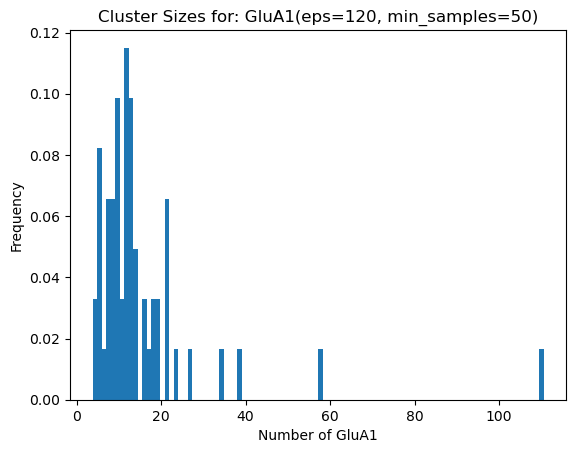

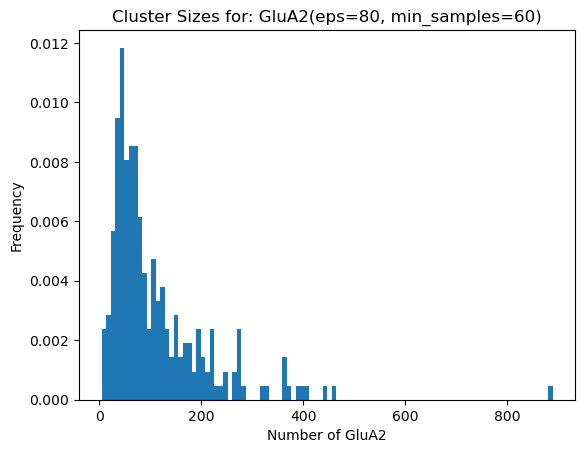

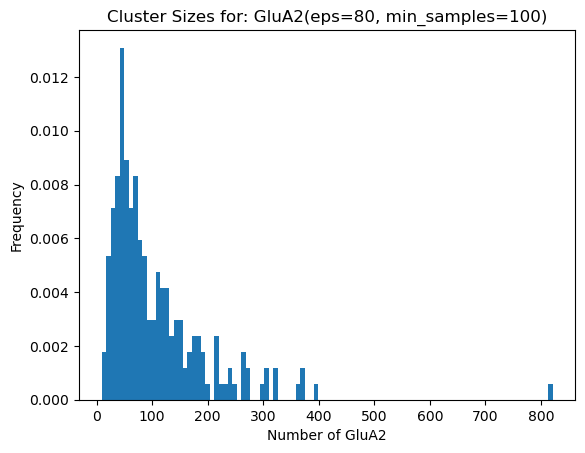

In [445]:
TestFOV.cluster_size_histogram(97.5, Params=Params, max_dark_time=100)

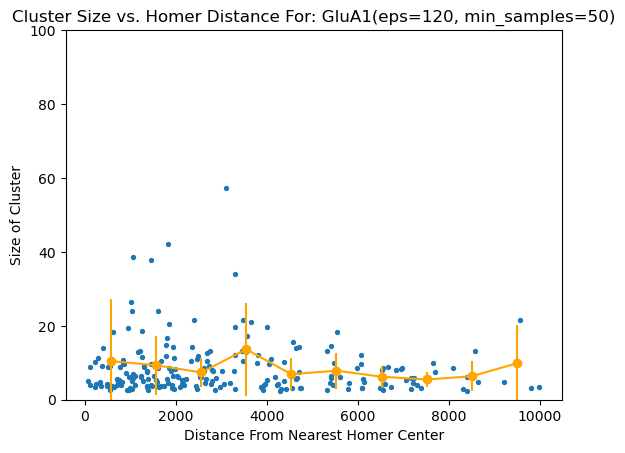

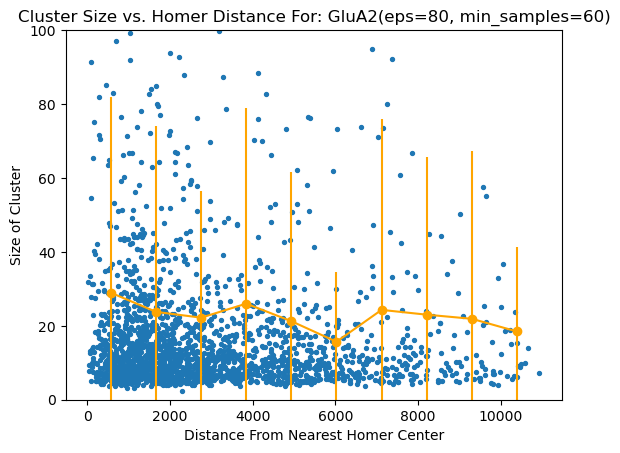

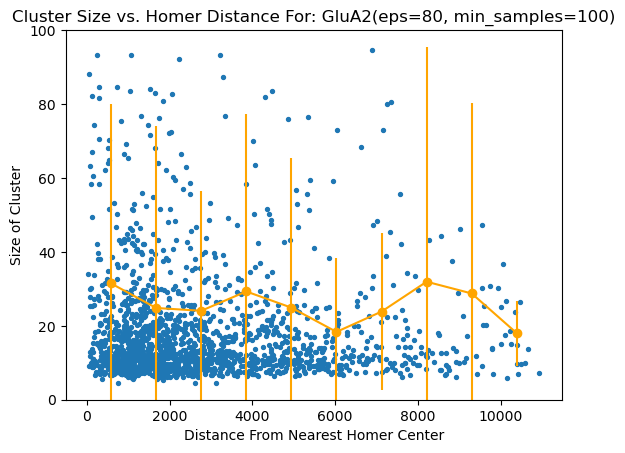

In [438]:
TestFOV.cluster_size_by_distance_to_homer_center(97.5, Params=Params, num_bins=10, y_top=100)

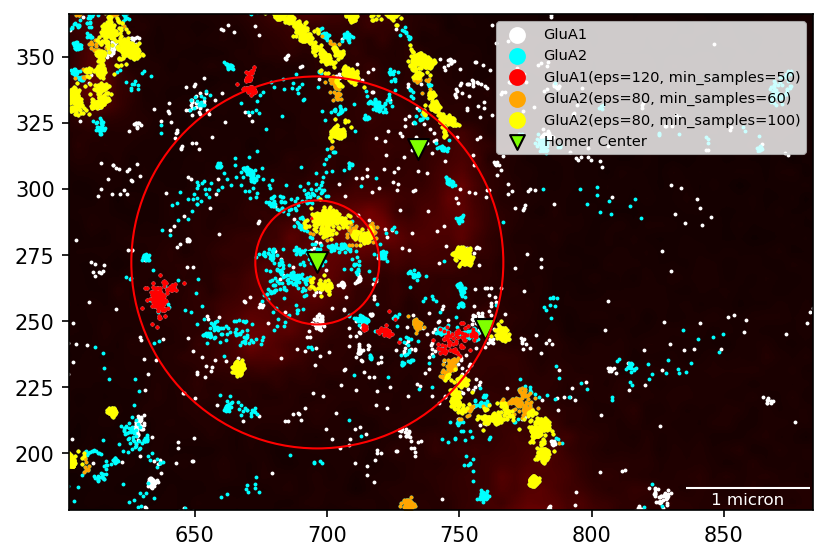

In [443]:
TestFOV.plot_homer(17, Params=Params, circle_radii=[500, 1500], show_points=['GluA1', 'GluA2'], other_homers=True)

In [400]:
TestFOV.clustering_results[Param3][3].plot(buffer=1500, nearby_points=True)
TestFOV.clustering_results[Param3][3].frames.get_average_dark_time(plot=True)

KeyError: GluA2(eps=60, min_samples=100)